In [1]:
import pandas as pd
from biom import load_table
import matplotlib.pyplot as plt
import numpy as np
from skbio import TreeNode
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

In [2]:
metadata = pd.read_table('../data/ag_map_with_alpha.txt', index_col=0)
table = load_table('../data/deblur_125nt_no_blooms.biom')
ids = pd.read_table('../data/plants.ids', dtype=np.str, header=None)
tree = TreeNode.read('../data/ag_tree.tre')

/Users/mortonjt/miniconda3/envs/gneiss_env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
taxa = pd.read_table('../data/taxa.txt', index_col=0)

Here we will perform some filtering based on low abundance, sparsity and variance

In [4]:
otu_filter = lambda val, id_, md: val.sum() > 10
var_filter = lambda val, id_, md: np.var(val) > 10
sparse_filter = lambda val, id_, md: (val>0).sum() > 10
id_filter = lambda val, id_, md: id_ in ids[0].values
table = table.filter(id_filter, axis='sample')
table = table.filter(otu_filter, axis='observation')
#table = table.filter(var_filter, axis='observation')
table = table.filter(sparse_filter, axis='observation')

table = pd.DataFrame(np.array(table.matrix_data.todense()).T, 
                     index=table.ids(axis='sample'),
                     columns=table.ids(axis='observation'))

Now we will clean the labels, merge together the categories "Less than 5" and "6 to 10" together. We'll only compare those categories to "More than 30", so we'll drop the other categories.

In [5]:
from gneiss.util import match
def preprocess_plants(x):
    if x in 'Less than 5' or x in '6 to 10':
        return 'Less than 10'
    elif x in 'More than 30':
        return 'More than 30'
    else:
        return np.nan
metadata['cleaned_plants'] = metadata.types_of_plants.apply(preprocess_plants)
metadata = metadata.dropna(subset=['cleaned_plants'])
table, metadata = match(table, metadata)

In [6]:
metadata.cleaned_plants.value_counts()

Less than 10    35
More than 30    33
Name: cleaned_plants, dtype: int64

In [7]:
from sklearn.exceptions import ConvergenceWarning
from skbio.stats.composition import closure
from sklearn.linear_model import (LogisticRegressionCV,
                                  RandomizedLogisticRegression)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from skbio.stats.composition import clr, centralize, multiplicative_replacement
from numpy.random import RandomState

le = preprocessing.LabelEncoder()
le.fit(metadata.cleaned_plants)
y = le.transform(metadata.cleaned_plants)
clf = ExtraTreesClassifier(100, random_state=0)
clf.fit(table.values, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [8]:
scores = pd.Series(clf.feature_importances_, index=table.columns)

clf = RandomizedLogisticRegression(random_state=1234, n_resampling=2000).fit(closure(table.values), y)

clf.scores_

In [9]:
table = table.loc[:, clf.feature_importances_>0.004]

In [10]:
tree = tree.shear(table.columns)

In [11]:
from gneiss.util import rename_internal_nodes
tree = rename_internal_nodes(tree)

In [12]:
from gneiss.composition import ilr_transform
from skbio.stats.composition import clr, centralize, multiplicative_replacement
from gneiss.cluster import correlation_clustering
ctable = pd.DataFrame(multiplicative_replacement(table),
                      index=table.index, columns=table.columns)
#tree = correlation_clustering(ctable)
balances = ilr_transform(ctable, tree)

In [13]:
from gneiss.regression import ols
res = ols("C(country)+C(types_of_plants)", balances, metadata)
res.fit() 

In [14]:
res.pvalues.loc['C(types_of_plants)[T.More than 30]'].sort_values()

y20    0.001979
y16    0.002476
y22    0.004234
y33    0.004266
y15    0.004625
y13    0.004865
y2     0.005975
y12    0.010110
y11    0.013411
y26    0.020027
y39    0.032346
y1     0.034235
y21    0.044476
y37    0.047796
y23    0.050114
y34    0.077484
y17    0.126673
y3     0.134705
y18    0.170187
y36    0.173965
y30    0.197604
y5     0.227024
y28    0.235774
y6     0.284000
y8     0.332890
y19    0.457867
y10    0.469368
y0     0.482471
y9     0.506382
y38    0.506840
y25    0.614266
y14    0.652748
y29    0.709545
y32    0.719691
y24    0.737768
y4     0.745830
y27    0.821990
y31    0.850504
y35    0.871034
y40    0.882874
y7     0.984940
Name: C(types_of_plants)[T.More than 30], dtype: float64

In [15]:
y = res.pvalues.apply(np.argmin, axis=1)['C(types_of_plants)[T.More than 30]']

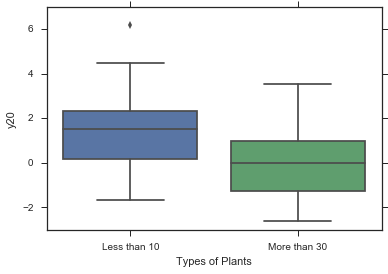

In [16]:
import seaborn as sns
data = pd.merge(balances, metadata, left_index=True, right_index=True)
fig = plt.figure()
sns.boxplot(y=y, x='cleaned_plants', data=data, order=['Less than 10', 'More than 30'])
plt.xlabel('Types of Plants')
fig.savefig('plants.pdf')

In [17]:
def fastaize(x, title=""):
    k = [">%s%d\n%s" % (title, i, s) for i, s in enumerate(x)]
    return '\n'.join(k)

In [18]:
from gneiss.util import NUMERATOR, DENOMINATOR
num = list(tree.find(y).children[NUMERATOR].subset())
#print(fastaize(num, title='numerator'))

In [19]:
taxa.loc[tree.find(y).children[NUMERATOR].subset()]

,0,1,2,3,4,5,6
TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGGAGCAGGCGGCGGCAGAGGTCTGTGGTGAAAGACTGAAGCTTAACTTCAGTAAGCCATAGAAACCGGGCTGCTAGAGTGC,k__Bacteria,p__Firmicutes,c__Erysipelotrichi,o__Erysipelotrichales,f__Erysipelotrichaceae,g__,s__
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCATGTAGGCGGCCTATTAAGTCGGGCGTGAAAATGCGGGGCTCAACCCCGTATGGCGCCCGATACTGGTGGGCTTGAGTGC,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Veillonellaceae,g__Phascolarctobacterium,s__
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCTTCCCAAGTCCCTCTTAAAAGTGCGGGGCTTAACCCCGTGATGGGAAGGAAACTGGGAAGCTGGAGTAT,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Veillonellaceae,g__Dialister,s__
TACGTAGGTGGCAAGCGTTATCCGGAATCATTGGGCGTAAAGGGTGCGTAGGTGGCACGATAAGTCTGAAGTAAAAGGCAACAGCTCAACTGTTGTATGCTTTGGAAACTGTCGAGCTAGAGTGC,k__Bacteria,p__Firmicutes,c__Erysipelotrichi,o__Erysipelotrichales,f__Erysipelotrichaceae,g__[Eubacterium],s__dolichum


In [20]:
denom = list(tree.find(y).children[DENOMINATOR].subset())
print(fastaize(denom, title='denominator'))

>denominator0
TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGATAGGCAAGTCAGTGGTGAAATCTATGGGCTTAACCCATAAACTGCCATTGAAACTGTTTATCTTGAGTG
>denominator1
TACGTAGGTGGCGAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGTGTAGGCGGGACTGCAAGTCAGATGTGAAAATTACGGGCTCAACTCGTAAAGTGCATTTGAAACTGTGGTTCTTGAGAG
>denominator2
TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGCGAGGCAAGTCAGGCGTGAAATCTATGGGCTTAACCCATAAACTGCGCTTGAAACTGTCTTGCTTGAGTG
>denominator3
TACGTAGGTGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGACTGCAAGTCAGGCGTGAAAACCACGGGCTCAACCTGTGGCCTGCGTTTGAAACTGTAGTTCTTGAGTG
>denominator4
TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGTGTAAAGGGTGCGTAGGCGGGTCGTAAAGTCAGATGTGAAATGCGGAGGCTCAACCTCCGAACTGCATTTGAAACTTACGATCTTGAGTG
>denominator5
TACGTAGGGGGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCGCGTAGACGGCTGTGTAAGTTATAGGTGAAAGCCCAACTTTCAAGGTTGGAACTGCCTGTAATACTGCATGGCTTGAGTG
>denominator6
TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGATTTTTAAGTGAGATGTGAAATACTCGGGCTTAACCTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTG
>denominator7
TACGTA

In [21]:
def f(x):
    tabs = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    x_ = x
    for i in range(1, len(x)):
        if x[i] in tabs:
            x_[i] = x[i-1]
    return x_
taxa = taxa.loc[num+denom]
taxa.apply(f, axis=1)

,0,1,2,3,4,5,6
TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGGAGCAGGCGGCGGCAGAGGTCTGTGGTGAAAGACTGAAGCTTAACTTCAGTAAGCCATAGAAACCGGGCTGCTAGAGTGC,k__Bacteria,p__Firmicutes,c__Erysipelotrichi,o__Erysipelotrichales,f__Erysipelotrichaceae,f__Erysipelotrichaceae,f__Erysipelotrichaceae
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCATGTAGGCGGCCTATTAAGTCGGGCGTGAAAATGCGGGGCTCAACCCCGTATGGCGCCCGATACTGGTGGGCTTGAGTGC,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Veillonellaceae,g__Phascolarctobacterium,g__Phascolarctobacterium
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCTTCCCAAGTCCCTCTTAAAAGTGCGGGGCTTAACCCCGTGATGGGAAGGAAACTGGGAAGCTGGAGTAT,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Veillonellaceae,g__Dialister,g__Dialister
TACGTAGGTGGCAAGCGTTATCCGGAATCATTGGGCGTAAAGGGTGCGTAGGTGGCACGATAAGTCTGAAGTAAAAGGCAACAGCTCAACTGTTGTATGCTTTGGAAACTGTCGAGCTAGAGTGC,k__Bacteria,p__Firmicutes,c__Erysipelotrichi,o__Erysipelotrichales,f__Erysipelotrichaceae,g__[Eubacterium],s__dolichum
TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGATAGGCAAGTCAGTGGTGAAATCTATGGGCTTAACCCATAAACTGCCATTGAAACTGTTTATCTTGAGTG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Ruminococcus,g__Ruminococcus
TACGTAGGTGGCGAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGTGTAGGCGGGACTGCAAGTCAGATGTGAAAATTACGGGCTCAACTCGTAAAGTGCATTTGAAACTGTGGTTCTTGAGAG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,f__Ruminococcaceae,f__Ruminococcaceae
TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGCGAGGCAAGTCAGGCGTGAAATCTATGGGCTTAACCCATAAACTGCGCTTGAAACTGTCTTGCTTGAGTG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Ruminococcus,g__Ruminococcus
TACGTAGGTGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGACTGCAAGTCAGGCGTGAAAACCACGGGCTCAACCTGTGGCCTGCGTTTGAAACTGTAGTTCTTGAGTG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Oscillospira,g__Oscillospira
TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGTGTAAAGGGTGCGTAGGCGGGTCGTAAAGTCAGATGTGAAATGCGGAGGCTCAACCTCCGAACTGCATTTGAAACTTACGATCTTGAGTG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,f__Ruminococcaceae,f__Ruminococcaceae
TACGTAGGGGGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCGCGTAGACGGCTGTGTAAGTTATAGGTGAAAGCCCAACTTTCAAGGTTGGAACTGCCTGTAATACTGCATGGCTTGAGTG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Christensenellaceae,f__Christensenellaceae,f__Christensenellaceae


In [22]:
data

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,vioscreen_vitk,vioscreen_water,vioscreen_wgrain,vioscreen_xylitol,vioscreen_zinc,seq_depth,observed_otus_1250,faiths_pd_1250,shannon_1250,cleaned_plants
#SampleID,,,,,,,,,,,,,,,,,,,,,
10317.000039882,2.616560,0.230472,4.036874e+00,0.340013,1.292749e-17,5.211582e+00,1.631355e-16,-4.637158,1.590301e-16,-1.965277e+00,...,256.151092529,3426.906494141,3.119260073,0.045917813,8.763643265,9010.0,93.1,11.940176,4.511293,More than 30
10317.000041323,1.671899,1.005073,4.896676e+00,-1.667965,-5.355829e-17,-1.496453e-15,-3.061964e+00,1.725973,5.324647e-16,-3.748475e-17,...,785.099975586,5211.153320312,2.941753387,0.02569863,6.500464916,7574.0,158.7,17.462958,5.183831,More than 30
10317.000042739,3.245174,0.581129,5.804384e+00,0.857332,-2.975313e-18,8.938726e-01,3.312728e-16,0.256179,3.550395e-16,-1.182054e+00,...,625.171508789,6682.938964844,0.747945189,0.238931507,21.091669083,6272.0,91.0,11.924759,5.072301,More than 30
10317.000043160,2.399547,0.866459,5.471724e+00,-1.389567,-4.111510e-17,1.305197e+00,-2.592677e+00,1.491484,4.524390e-16,-3.992886e-18,...,1611.616088867,5294.499511719,1.015479445,0.078136995,12.739616394,7915.0,202.8,20.055343,6.199623,More than 30
10317.000038225,-0.451988,0.872555,1.767289e+00,1.287269,-1.827741e-17,2.281560e+00,3.531071e-16,1.698968,3.381610e-16,1.316508e-17,...,484.528686523,3501.0703125,1.027808309,0.051068496,9.888712883,15757.0,167.7,18.444216,5.578238,More than 30
10317.000040027,0.111332,1.269943,1.978298e+00,-0.617791,-7.144411e-01,3.378937e+00,2.421128e+00,-0.894302,1.237448e+00,-4.300099e+00,...,164.365951538,2660.393798828,0,0.045424659,13.22490406,10591.0,119.7,13.600975,4.839023,Less than 10
10317.000042021,1.152055,0.849615,2.200460e+00,-0.733874,1.429238e+00,3.665952e+00,1.931308e+00,1.508585,3.473440e-16,6.643109e-17,...,176.779769897,3107.085205078,1.969232917,0.032082189,10.136986732,11792.0,68.4,9.423768,4.275811,Less than 10
10317.000022510,1.278762,0.827048,-2.601849e+00,-0.794427,-2.908955e+00,3.854125e-16,1.957800e+00,1.462646,-5.038458e+00,1.693481e-17,...,292.642883301,2468.1328125,0.005917809,0.019561645,4.652657032,6218.0,123.2,14.566186,5.058702,Less than 10
10317.000015826,-1.727947,0.834678,-1.226167e-15,1.231389,-2.061441e-17,2.804313e-16,2.694652e-16,1.625216,3.352620e-16,4.588441e-17,...,278.042175293,3445.409667969,3.106109858,0.02131507,9.718437195,11598.0,93.1,11.792963,4.108792,More than 30


In [23]:
import seaborn as sns
data = pd.merge(table[num], metadata[['cleaned_plants']], left_index=True, right_index=True)
#data = pd.merge(balances, metadata, left_index=True, right_index=True)

#name = 'TACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGTTATGTAAGTCAGGGGTGAAATCCCACGGCTCAACCGTGGAACTGCCCTTGATACTGCACGACTTGAATC'
#data = pd.merge(table[name], 
#                metadata[['cleaned_plants']], left_index=True, right_index=True)
data = pd.melt(data, id_vars=['cleaned_plants'], value_vars=names, 
               value_name='count', var_name='sequence')
data = data.dropna(subset=['count'])

fig = plt.figure()
g = sns.barplot(x='count', hue='cleaned_plants', 
                y='sequence', data=data,
                #palette={'More than 30': 'green', 'Less than 10': '#F7CE2B'},
                #order=['Less than 10', 'More than 30']
)
_ = g.set(yticklabels=taxa.loc[num, '6'].values)

#plt.xlabel('Types of Plants')
#plt.tight_layout()
#plt.ylim([-5, 3.5])
#fig.savefig('types_of_plants_boxplot.pdf')

NameError: name 'names' is not defined

In [24]:
import seaborn as sns
data = pd.merge(table[denom], metadata[['cleaned_plants']], left_index=True, right_index=True)
#data = pd.merge(balances, metadata, left_index=True, right_index=True)


#name = 'TACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGTTATGTAAGTCAGGGGTGAAATCCCACGGCTCAACCGTGGAACTGCCCTTGATACTGCACGACTTGAATC'
#data = pd.merge(table[name], 
#                metadata[['cleaned_plants']], left_index=True, right_index=True)

data = pd.melt(data, id_vars=['cleaned_plants'], value_vars=names, 
               value_name='count', var_name='sequence')
data = data.dropna(subset=['count'])
fig, ax = plt.subplots()
g = sns.barplot(x='count', hue='cleaned_plants', y='sequence', data=data, ax=ax,
            #palette={'More than 30': 'green', 'Less than 10': '#F7CE2B'},
            #order=['Less than 10', 'More than 30']
)

#ax.set_yticklabels(taxa.loc[denom, '6'].values)
_ = g.set(yticklabels=taxa.loc[denom, '6'].values)
#plt.xlabel('Types of Plants')
#plt.tight_layout()
#plt.ylim([-5, 3.5])
#fig.savefig('types_of_plants_boxplot.pdf')


NameError: name 'names' is not defined

In [25]:
len(denom)

12

In [26]:
len(denom)

12

In [27]:
taxa.loc[denom, '6'].shape

(12,)

In [28]:
taxa.loc[num, '6'].values

array(['f__Erysipelotrichaceae', 'g__Phascolarctobacterium',
       'g__Dialister', 's__dolichum'], dtype=object)

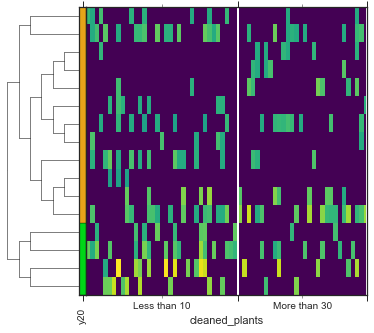

In [29]:
from gneiss.plot import heatmap

highlights = pd.DataFrame([['#00D617', '#E6A519']],
                          index=['y20'], 
                          columns=['numerator', 'denominator'])
ctable = table[num + denom]
ctable = ctable.loc[ctable.sum(axis=1)>0]
ctable, metadata = match(ctable, metadata)
#ctable = pd.DataFrame(clr(centralize(multiplicative_replacement(ctable+10e-10))),
#                      index=ctable.index, columns=ctable.columns)
axes = heatmap(np.log(ctable+10e-5),  tree.find('y20'), metadata.cleaned_plants, highlights=highlights)

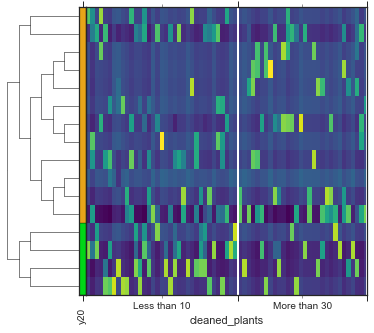

In [30]:
from gneiss.plot import heatmap

highlights = pd.DataFrame([['#00D617', '#E6A519']],
                          index=['y20'], 
                          columns=['numerator', 'denominator'])
ctable = table[num + denom]
ctable = ctable.loc[ctable.sum(axis=1)>0]
ctable, metadata = match(ctable, metadata)
ctable = pd.DataFrame(clr(centralize(multiplicative_replacement(ctable))),
                      index=ctable.index, columns=ctable.columns)
axes = heatmap(ctable,  tree.find('y20'), metadata.cleaned_plants, highlights=highlights)

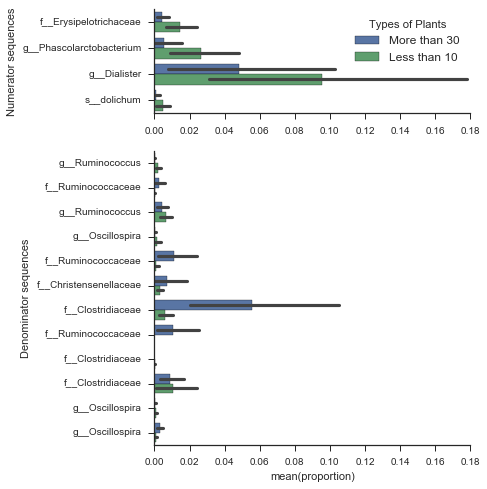

In [31]:
import seaborn as sns
sns.set_style('ticks')
from matplotlib.gridspec import GridSpec
gs = GridSpec(100, 100)
plt.figure(figsize=(7, 7))
ax1 = plt.subplot(gs[:30, :])
ax2 = plt.subplot(gs[30:, :], sharex=ax1)

sns.set_style('ticks')
sns.set(font_scale=1.2)  # crazy big

ctable = pd.DataFrame(closure(table), index=table.index, columns=table.columns)
cmetadata = metadata.copy()
cmetadata['Types of Plants'] = metadata[['cleaned_plants']]
data_num = pd.merge(ctable[num], cmetadata[['Types of Plants']], left_index=True, right_index=True)
data_denom = pd.merge(ctable[denom], cmetadata[['Types of Plants']], left_index=True, right_index=True)
#data = pd.concat((data_num, data_denom.iloc[:, :-2]), axis=1)

data_num = pd.melt(data_num, id_vars=['Types of Plants'], value_vars=num, 
                   value_name='proportion', var_name='Numerator sequences')
data_denom = pd.melt(data_denom, id_vars=['Types of Plants'], value_vars=denom, 
                     value_name='proportion', var_name='Denominator sequences')

#data['location'] = data.sequence.apply(lambda x: 'numerator' if x in num else 'denominator')
data_num = data_num.dropna(subset=['proportion'])

data_denom = data_denom.dropna(subset=['proportion'])

g = sns.barplot(x='proportion', hue='Types of Plants', 
                y='Numerator sequences', 
                data=data_num,
                #palette={'More than 30': 'green', 'Less than 10': '#F7CE2B'},
                #order=['Less than 10', 'More than 30'],
                ax=ax1
)
_ = g.set(yticklabels=taxa.loc[num, '6'].values)
_ = g.set(xlabel="")

g = sns.barplot(x='proportion', hue='Types of Plants', 
                y='Denominator sequences', 
                data=data_denom,
                #palette={'More than 30': 'green', 'Less than 10': '#F7CE2B'},
                #order=['Less than 10', 'More than 30'],
                ax=ax2
)
_ = g.set(yticklabels=taxa.loc[denom, '6'].values, )
plt.tight_layout()
ax2.legend_.remove()
# ax2.set_xticklabels('')
sns.despine()
plt.savefig('Types_of_Plants_barplot.pdf')

In [32]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

#sns.set_style('ticks')
sns.set(font_scale=1.1)  # crazy big

ctable = pd.DataFrame(closure(table), index=table.index, columns=table.columns)
cmetadata = metadata.copy()
cmetadata['Types of Plants'] = metadata[['cleaned_plants']]
data_num = pd.merge(ctable[num], cmetadata[['Types of Plants']], left_index=True, right_index=True)
data_denom = pd.merge(ctable[denom], cmetadata[['Types of Plants']], left_index=True, right_index=True)
data = pd.concat((data_num, data_denom.iloc[:, :-2]), axis=1)
data = pd.melt(data, id_vars=['Types of Plants'], value_vars=num+denom, 
               value_name='proportion', var_name='sequence')

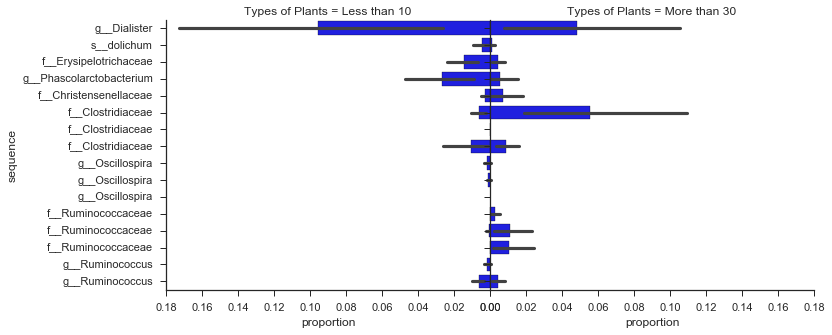

In [33]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

sns.set_style('ticks')
#data['location'] = data.sequence.apply(lambda x: 'numerator' if x in num else 'denominator')
data = data.dropna(subset=['proportion'])
data['log_proportion'] = np.log(data['proportion']+1e-5)

num_idx = np.argsort(list(map(lambda x: x[3:].lower(), taxa.loc[num, '6'].values)))
num_taxa = taxa.loc[[num[i] for i in num_idx], '6']

denom_idx = np.argsort(list(map(lambda x: x[3:].lower(), taxa.loc[denom, '6'].values)))
denom_taxa = taxa.loc[[denom[i] for i in denom_idx], '6']

g = sns.factorplot(x='proportion',  
                   y='sequence', 
                   col='Types of Plants',
                   data=data,
                   kind='bar',
                   size=5,
                   aspect=1.5,
                   color='b',
                   col_order=['Less than 10', 'More than 30'],
                   order=list(num_taxa.index)+list(denom_taxa.index),
                   #hue='Types of Plants',
                   sharex=False
)
_ = g.set(yticklabels=taxa.loc[list(num_taxa.index)+list(denom_taxa.index), '6'].values)
[[ax1, ax2]] = g.axes
max_xlim = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
min_xlim = max(ax1.get_xlim()[0], ax2.get_xlim()[0])
xlim = ([min_xlim, max_xlim])
ax1.set_xlim(max_xlim, min_xlim)
ax2.set_xlim(min_xlim, max_xlim)
#_ = g.set(xlabel="")
ax1.set_position([0.2, 0.125, 0.3, 0.75])
ax2.set_position([0.5, 0.125, 0.3, 0.75])

# plt.tight_layout()
plt.savefig('Types_of_Plants_cool.pdf')

In [34]:
tree.find('y20')

<TreeNode, name: y20, internal node count: 14, tips count: 16>

In [35]:
from gneiss.util import NUMERATOR, DENOMINATOR

balance_summary = pd.concat((taxa.loc[tree.find('y20').children[NUMERATOR].subset()],
                             taxa.loc[tree.find('y20').children[DENOMINATOR].subset()]))

In [36]:
def position(x):
    if (x in tree.find('y20').children[NUMERATOR].subset()):
        return 'numerator'
    else:
        return 'denominator'

balance_summary['balance'] = 'y20'
balance_summary['position'] = list(map(position, balance_summary.index))

In [37]:
balance_summary.to_csv('types_of_plants_balance_summary.csv')